In [54]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [55]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import mpl_toolkits
#from mpl_toolkits.basemap import Basemap
import pandas as pd
import xarray as xr
import Nio
print (Nio.__version__)
#import seaborn as seabornInstance
from scipy import stats
#import sklearn

print("python version:")
import platform
print(platform.python_version())

1.5.5
python version:
3.7.3


In [56]:
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def correlation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

# Load Data

In [57]:
dat = xr.open_dataset('/global/scratch/medhap02/ISMData/ERA5_MSLP_SST_Td_tas_Jan1979toMay2020.grib',engine='pynio')

sst = dat['SSTK_GDS0_SFC_S123']
sst = sst.rename({'g0_lon_2':'lon', 'g0_lat_1':'lat', 'initial_time0_hours':'time'})

slp = dat['MSL_GDS0_SFC_S123']
slp = slp.rename({'g0_lon_2':'lon', 'g0_lat_1':'lat', 'initial_time0_hours':'time'})

In [58]:
precipdat = xr.open_dataset('/global/scratch/medhap02/ISMData/pALLIN.nc', decode_times=False)
print(precipdat)
time = pd.date_range('1871-02-01', freq='M', periods=1752)

precip = precipdat['precip']
precip['time'] = time

def is_jjas(month):
    return (month >= 6) & (month <= 9)

precipJJAS = precip.sel(time=is_jjas(precip['time.month'])).groupby('time.year').sum(dim='time')

<xarray.Dataset>
Dimensions:  (time: 1752)
Coordinates:
  * time     (time) float32 0.0 1.0 2.0 3.0 4.0 ... 1748.0 1749.0 1750.0 1751.0
Data variables:
    precip   (time) float32 ...
Attributes:
    title:        
    description:  All-India Rainfall
    scripturl01:  https://climexp.knmi.nl/getindices.cgi?STATION=All-India_Ra...
    comment:      
    institution:  KNMI Climate Explorer
    scripturl02:  https://climexp.knmi.nl/dat2nc.cgi?id=$id&station=All-India...
    history:       2020-04-02  2:43:20 bin/dat2nc data/pALLIN.dat p All-India...
    Conventions:  CF-1.0


# Precipitation Data


In [59]:
'''
pIITM = precipdat['precip']
pIITM['time'] = time

def is_jjas(month):
    return (month >= 6) & (month <= 9)

pIITMJJAS = pIITM.sel(time=is_jjas(pIITM['time.month'])).groupby('time.year').sum(dim='time')
pIITMJJAS.mean()
print(pIITMJJAS)
'''

"\npIITM = precipdat['precip']\npIITM['time'] = time\n\ndef is_jjas(month):\n    return (month >= 6) & (month <= 9)\n\npIITMJJAS = pIITM.sel(time=is_jjas(pIITM['time.month'])).groupby('time.year').sum(dim='time')\npIITMJJAS.mean()\nprint(pIITMJJAS)\n"

## add IMD rainfall for 2012 - 2019 to observed time series

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


(2000, 2020)

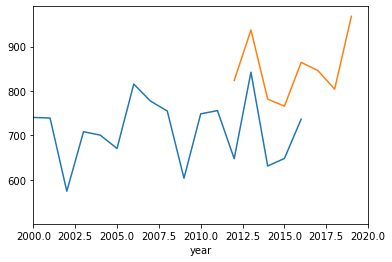

In [60]:
pIMDJJASupdateArray = np.array([823.6, 937.4, 781.7, 765.8, 864.4, 845.9, 804.1, 968.3] )
yearUpdate = np.arange(2012,2020)

# 2012 - 2018 values are from IMD reports obtained from their Hydromet division,
#  Customized Rainfall Information System (CRIS), 
#  http://hydro.imd.gov.in/hydrometweb/(S(gk24v0qwwwzr5hqr335i0q55))/landing.aspx#
#  2019 report not yet available so obtained from news articles citing IMD,
#  https://weather.com/en-IN/india/monsoon/news/2019-09-30-wettest-september-india-records-highest-monsoon-rainfall-25-years
#
pIMDJJASnormals = 886.9
pIMDJJASupdate = xr.DataArray(pIMDJJASupdateArray,coords={'year':yearUpdate},dims=['year'])
#pIMDJJAS = xr.concat([ptmpJJAS,pIMDJJASupdate],dim='year')
precipJJAS.plot()
pIMDJJASupdate.plot()
plt.xlim(2000,2020)

# EPT

In [61]:
#EP-ENSOpredictor

#DSST1
latrange1 = sst.sel(lat = slice(5, -20)).lat
weights1 = np.cos(latrange1*np.pi/180)

marchdata1 = sst.sel(lat = slice(5, -20), lon = slice(150, 170), time = (sst['time.month']==3))
marchSST1 = marchdata1.sel(time = slice('1979-03-01', '2020-03-01'))
marchmean1 = (marchSST1*weights1).mean({'lon', 'lat'})/weights1.mean() - 273.15

maydata1 = sst.sel(lat = slice(5, -20), lon = slice(150, 170), time = (sst['time.month']==5))
maySST1 = maydata1.sel(time = slice('1979-05-01', '2020-05-01'))
maymean1 = (maySST1*weights1).mean({'lon', 'lat'})/weights1.mean() - 273.15

marchmean1.time.data = maymean1.time.data
DSST1 = maymean1 - marchmean1

#DSST2
latrange2 = sst.sel(lat = slice(10, -10)).lat
weights2 = np.cos(latrange2*np.pi/180)

marchdata2 = sst.sel(lat = slice(10, -10), lon = slice(250, 280), time = (sst['time.month']==3))
marchSST2 = marchdata2.sel(time = slice('1979-03-01', '2020-03-01'))
marchmean2 = (marchSST2*weights2).mean({'lon', 'lat'})/weights2.mean() - 273.15

maydata2 = sst.sel(lat = slice(10, -10), lon = slice(250, 280), time = (sst['time.month']==5))
maySST2 = maydata2.sel(time = slice('1979-05-01', '2020-05-01'))
maymean2 = (maySST2*weights2).mean({'lon', 'lat'})/weights2.mean() - 273.15

marchmean2.time.data = maymean2.time.data
DSST2 = (maymean2 - marchmean2)

EPT = DSST1 - DSST2
EPTstd = 0.546494
EPTmean = -0.036233
EPT = (EPT - EPTmean)/EPTstd

print(EPT)

<xarray.DataArray (time: 42)>
array([-0.941544, -0.214084,  0.030282, -0.07727 , -0.447282,  0.888805,
        1.368212,  0.660074, -0.716499,  1.504635,  0.158218, -0.696619,
       -0.578401, -0.755645, -0.533615, -0.065432,  0.918736,  0.998647,
       -1.468083,  0.881545,  1.271437,  0.406493,  0.928453,  0.678725,
        2.071716,  1.229444, -1.027318,  1.065769,  1.295282, -0.276125,
       -1.021622,  0.908238, -0.286568,  0.434749,  2.190772, -0.171421,
       -1.795878,  1.190801,  0.617243, -0.750898, -0.15746 , -0.691146],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2020-05-01


# CPT

In [62]:
#CP-ENSOpredictor

#DSST1
latrange1 = sst.sel(lat = slice(-10, -25)).lat
weights1 = np.cos(latrange1*np.pi/180)

aprildata1 = sst.sel(lat = slice(-10, -25), lon = slice(170, 200), time = (sst['time.month']==4))
aprilSST1 = aprildata1.sel(time = slice('1979-04-01', '2020-04-01'))
aprilmean1 = (aprilSST1*weights1).mean({'lon', 'lat'})/weights1.mean() - 273.15

maydata1 = sst.sel(lat = slice(-10, -25), lon = slice(170, 200), time = (sst['time.month']==5))
maySST1 = maydata1.sel(time = slice('1979-05-01', '2020-05-01'))
maymean1 = (maySST1*weights1).mean({'lon', 'lat'})/weights1.mean() - 273.15

aprilmean1.time.data = maymean1.time.data
DSST1 = maymean1 - aprilmean1

#DSST2
latrange2 = sst.sel(lat = slice(20, 5)).lat
weights2 = np.cos(latrange2*np.pi/180)

aprildata2 = sst.sel(lat = slice(20, 5), lon = slice(180, 210), time = (sst['time.month']==4))
aprilSST2 = aprildata2.sel(time = slice('1979-04-01', '2020-04-01'))
aprilmean2 = (aprilSST2*weights2).mean({'lon', 'lat'})/weights2.mean() - 273.15
                          
maydata2 = sst.sel(lat = slice(20, 5), lon = slice(180, 210), time = (sst['time.month']==5))
maySST2 = maydata2.sel(time = slice('1979-05-01', '2020-05-01'))
maymean2 = (maySST2*weights2).mean({'lon', 'lat'})/weights2.mean() - 273.15
                          
aprilmean2.time.data = maymean2.time.data
DSST2 = maymean2 - aprilmean2

CPT = DSST1 - DSST2
CPTstd = 0.243743
CPTmean = -1.087295
CPT = (CPT - CPTmean)/CPTstd

print(CPT)

<xarray.DataArray (time: 42)>
array([ 0.700952, -0.055154, -0.919938,  1.224805, -1.449675, -0.457184,
        0.061911, -1.169845, -2.233076,  0.540816,  1.955871,  1.764059,
        0.351132, -1.134913, -0.943977, -1.232947, -0.126896, -0.953492,
        0.360523,  0.714474, -1.192256, -0.351262,  1.182987, -1.256736,
        0.556842, -0.150059, -0.930079,  0.768813,  1.299176,  0.891262,
       -1.348761,  1.112873,  1.451049, -0.005824, -0.624081, -0.681299,
        0.273005, -0.135034, -0.130151,  1.718985, -1.743529,  1.706089],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2020-05-01


# PSH

In [63]:
#mega-ENSOpredictor

#NPcalculation
latrange1 = slp.sel(lat = slice(-10, -40)).lat
weights1 = np.cos(latrange1*np.pi/180)

aprildata1 = slp.sel(lat = slice(-10, -40), lon = slice(200, 270), time = (slp['time.month']==4))
aprilSLP1 = aprildata1.sel(time=slice('1979-04-01','2020-04-01'))
aprilmean1 = ((aprilSLP1*weights1).mean({'lon', 'lat'})/weights1.mean())/100

maydata1 = slp.sel(lat = slice(-10, -40), lon = slice(200, 270), time = (slp['time.month']==5))
maySLP1 = maydata1.sel(time = slice('1979-05-01', '2020-05-01'))
maymean1 = ((maySLP1*weights1).mean({'lon', 'lat'})/weights1.mean())/100

aprilmean1.time.data = maymean1.time.data
NP = ((aprilmean1 + maymean1)/2)

#SPcalculation
latrange2 = slp.sel(lat = slice(30, 10)).lat
weights2 = np.cos(latrange2*np.pi/180)

aprildata2 = slp.sel(lat = slice(30, 10), lon = slice(180, 230), time = (slp['time.month']==4))
aprilSLP2 = aprildata2.sel(time = slice('1979-04-01', '2020-04-01'))
aprilmean2 = ((aprilSLP2*weights2).mean({'lon', 'lat'})/weights2.mean())/100

maydata2 = slp.sel(lat = slice(30, 10), lon = slice(180, 230), time = (slp['time.month']==5))
maySLP2 = maydata2.sel(time = slice('1979-05-01', '2020-05-01'))
maymean2 = ((maySLP2*weights2).mean({'lon', 'lat'})/weights2.mean())/100

aprilmean2.time.data = maymean2.time.data
SP = ((aprilmean2 + maymean2)/2)

NParea = (30*weights1.mean() * 60)
SParea = (20*weights2.mean() * 50)
PSH = ((NP * NParea) + (SP * SParea))/(NParea + SParea)
PSHstd = 0.430541
PSHmean = 1015.898018
PSH = (PSH - PSHmean)/PSHstd

print(PSH)

<xarray.DataArray (time: 42)>
array([-2.756130e+00, -8.713655e-01, -7.667529e-01, -1.544822e+00,
        1.489758e+00,  2.006463e+00,  4.033741e-04, -1.662678e+00,
        5.874371e-01,  1.858456e+00,  6.024921e-01,  8.573327e-01,
       -1.589522e+00, -1.626510e+00, -4.328931e-01, -2.878936e-01,
       -5.303527e-02,  2.497865e+00, -3.169923e+00,  2.797927e+00,
        2.454002e+00,  3.115514e+00,  2.352497e+00, -7.973652e-01,
        1.529795e+00,  1.486451e+00,  5.307314e-01, -3.200007e-01,
        3.632006e+00, -5.124011e-01, -1.059055e+00,  4.345244e+00,
        3.730894e+00,  1.681166e+00,  1.798154e+00,  2.470206e+00,
       -3.370156e-01, -3.774479e-01,  2.501067e+00,  1.364451e+00,
        2.111671e+00,  1.561978e+00])
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2020-05-01


# NAT

In [64]:
#AnomalousAsianLowpredictor

latrange = slp.sel(lat = slice(60, 40)).lat
weights = np.cos(latrange*np.pi/180)

marchdata = slp.sel(lat = slice(60, 40), lon = slice(95, 125), time = (slp['time.month']==3))
marchSLP = marchdata.sel(time = slice('1979-03-01', '2020-03-01'))
marchmean = ((marchSLP*weights).mean({'lon', 'lat'})/weights.mean())/100

maydata = slp.sel(lat = slice(60, 40), lon = slice(95, 125), time = (slp['time.month']==5))
maySLP = maydata.sel(time = slice('1979-05-01', '2020-05-01'))
maymean = ((maySLP*weights).mean({'lon', 'lat'})/weights.mean())/100

marchmean.time.data = maymean.time.data
NAT = maymean - marchmean
NATstd = 1.648686
NATmean = -12.909709
NAT = (NAT - NATmean)/NATstd

print(NAT)

<xarray.DataArray (time: 42)>
array([ 1.261128, -1.235645,  2.367263,  1.512127, -0.84519 , -0.310207,
       -0.761857,  1.554441,  1.187938, -0.502306,  1.936048,  1.334613,
       -0.2335  ,  1.636478,  0.89581 , -1.741974,  1.21326 ,  1.672907,
        0.697861,  0.774456,  2.649248,  1.257648,  1.693009,  5.703697,
        0.751837,  1.427572, -1.064203,  2.849492, -1.307983,  2.633403,
        0.154141, -0.642688, -0.873844,  0.276568,  1.539114,  0.663173,
        0.781083,  1.146364, -0.670046,  2.066397,  2.473104,  3.104415],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2020-05-01


# Precipitation

In [65]:
rainfallgraph = precipJJAS.sel(year = slice('1979', '2020')).data
rainfallmeangraph = rainfallgraph.mean()
rainfallstdgraph = rainfallgraph.std()
rainfallmodel = precipJJAS.sel(year = slice('1900', '1981')).data
rainfallmeanmodel = rainfallmodel.mean()
rainfallstdmodel = rainfallmodel.std()

# Model

In [66]:
#Dr. Wang's coefficients
AIRI = 0.47*EPT + 0.19*CPT + 0.23*PSH - 0.24*NAT
AIRI

<xarray.DataArray (time: 42)>
array([-1.245925, -0.014958, -0.905052, -0.521823,  0.059829,  0.866809,
        0.837761, -0.667517, -0.911034,  1.357932,  0.119899, -0.115361,
       -0.514683, -1.337639, -0.744714,  0.086845,  0.104315,  0.461212,
       -1.518069,  1.00773 ,  0.299648,  0.539045,  0.795893, -1.47206 ,
        1.250918,  0.548594, -0.282078, -0.110492,  2.004903, -0.710308,
       -1.017004,  1.791969,  1.20884 ,  0.523518,  0.955275,  0.198971,
       -1.057165,  0.172079,  1.001432, -0.208426, -0.513137, -0.386486])
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2020-05-01

In [67]:
final = (AIRI * rainfallstdmodel) + rainfallmeanmodel
print(final)

<xarray.DataArray (time: 42)>
array([648.152737, 729.304162, 670.624812, 695.889114, 734.234491, 787.434637,
       785.519643, 686.284236, 670.23045 , 819.811876, 738.194639, 722.685149,
       696.359835, 642.106548, 681.195041, 736.015557, 737.167258, 760.695643,
       630.211707, 796.724824, 750.044554, 765.826774, 782.759455, 633.244811,
       812.756995, 766.456299, 711.694332, 723.006103, 862.463397, 683.463273,
       663.244389, 848.425717, 809.98301 , 764.803147, 793.26675 , 743.407456,
       660.596733, 741.634606, 796.309596, 716.549785, 696.461734, 704.811191])
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2020-05-01


In [68]:
modelyears = []
for x in range(42):
    modelyears.append(x+1979)
modelyears2 = []
for x in range(38):
    modelyears2.append(x+1979)
observedrainfall = []
for x in range(38):
    observedrainfall.append(float(precipJJAS[x+108]))
correlationfinal = []
for x in range(38):
    correlationfinal.append(final.data[x])

In [69]:
#correlation
correlation = stats.pearsonr(correlationfinal, observedrainfall)
correlation = correlation[0]
print("Correlation between Model and Rainfall", correlation)

Correlation between Model and Rainfall 0.4557322468431844


In [71]:
rmse = 27.929032
prediction2020 = final.sel(time = slice('2020-05-01', '2020-05-01')).data
prediction = (prediction2020[0]/rainfallmeanmodel)
bounds = (rmse/rainfallmeanmodel)

In [72]:
predictiontxt = ('2020 prediction: '+"{:0.3f}".format(prediction)+ "+/-"+ "{:0.3f}".format(bounds)+ " of normal")
print(predictiontxt)
correlationtxt = ('r(prediction,obs) = '+"{:0.2f}".format(correlation))
print(correlationtxt)

2020 prediction: 0.965+/-0.038 of normal
r(prediction,obs) = 0.46


# Final Information and Graphics

Text(1978, 550, 'r(prediction,obs) = 0.46')

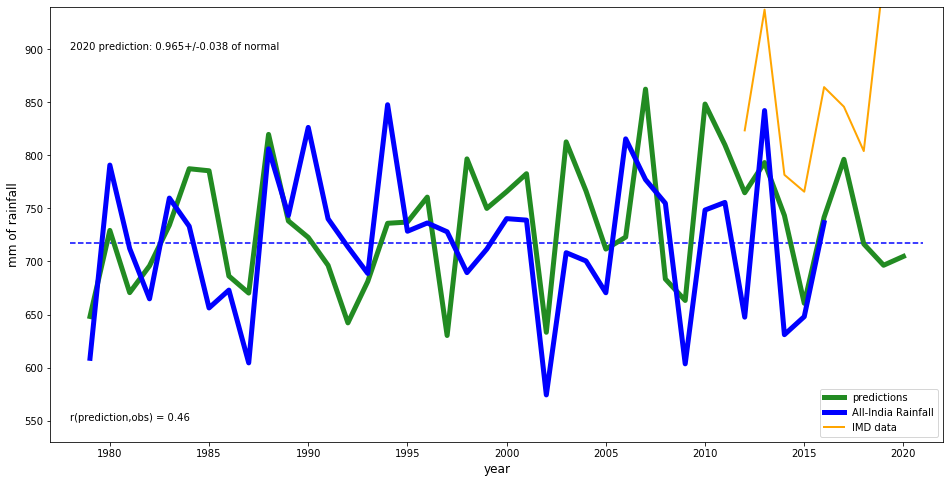

In [73]:
#print("2020 prediction", final.sel(time = slice('2020-05-01', '2020-05-01')))
plt.figure(figsize=(16,8))
plt.title('1979 - 2020 predictions', fontsize = 'xx-large')
plt.plot(modelyears, final, label = 'predictions', color = 'forestgreen',linewidth=5)
plt.plot(modelyears2, observedrainfall, label = 'All-India Rainfall', color = 'blue',linewidth=5)
#precipJJAS.sel(year=slice('1979','2020')).plot(linewidth=2,color='magenta',label='IITM data')
pIMDJJASupdate.sel(year=slice('1979','2020')).plot(linewidth=2,color='orange',label='IMD data')

axes = plt.gca()
axes.set_xlim([1977, 2022])
axes.set_ylim([530, 940])
plt.xlabel('year', fontsize = 'large')
plt.ylabel('mm of rainfall', fontsize = 'large')
plt.legend(loc='lower right')
plt.hlines(rainfallmeangraph,1978,2021,linestyles='dashed',colors='blue')
#ptmpJJAS.sel(year=slice('1979','2020')).plot(color='magenta')

plt.text(1978,900,predictiontxt)
plt.text(1978,550,correlationtxt)

In [75]:
print("Root Mean Square Error", rmse)
print("Rainfall Standard Deviation for Training Period", rainfallstdmodel)
print("Rainfall Mean for Training Period", rainfallmeanmodel)
airivalue = AIRI.sel(time = slice('2020-05-01', '2020-05-01')).data
print("Prediction's Standard Deviation Above or Below the Mean", airivalue[0])
print("2020 Prediction", prediction2020[0])
print("Correlation between Model and Rainfall", correlation)

Root Mean Square Error 27.929032
Rainfall Standard Deviation for Training Period 65.924934
Rainfall Mean for Training Period 730.2903
Prediction's Standard Deviation Above or Below the Mean -0.386486425346941
2020 Prediction 704.8111909705817
Correlation between Model and Rainfall 0.4557322468431844


In [78]:
print("Rainfall Standard Deviation for Training Period: 65.925")
print("Rainfall Mean for Training Period: 730.29")
print()
print("2020 Prediction: 815.4362mm of rainfall")
print("Prediction's Standard Deviation Above or Below the Mean: -0.3864")

print("Root Mean Square Error: 27.9290")

Rainfall Standard Deviation for Training Period: 65.925
Rainfall Mean for Training Period: 730.29

2020 Prediction: 815.4362mm of rainfall
Prediction's Standard Deviation Above or Below the Mean: -0.3864
Root Mean Square Error: 27.9290


In [79]:
np.mean(observedrainfall)
print(prediction2020[0])

704.8111909705817


## Instead plot results as fraction of long-term mean
This helps with the issue of IITM and IMD data having different long-term means.
Add error bar representing the RMSE between the two different input datasets for our predictions (HadSLP+NOAASST vs ERA5)

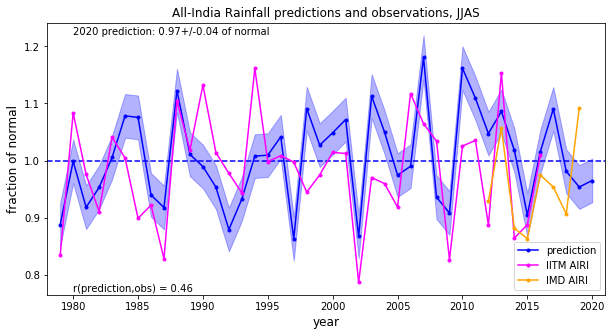

In [83]:
plt.figure(figsize=(10,5))
plt.fill_between(modelyears,(final+rmse)/rainfallmeanmodel,(final-rmse)/rainfallmeanmodel,color='blue',alpha=0.3)
plt.plot(modelyears, final/rainfallmeanmodel, label = 'prediction', color = 'blue',marker='.')
#plt.plot(modelyears2, observedrainfall/, label = 'All-India Rainfall', color = 'blue',linewidth=5)
IITMmean = precipJJAS.sel(year=slice(1951,2000)).mean()
IMDmean = 886.9  # from the IMD 2013 monsoon report for 1951-2000 normals, JJAS
(precipJJAS/IITMmean).sel(year=slice('1979','2020')).plot(color='magenta',marker='.',label='IITM AIRI')
(pIMDJJASupdate/IMDmean).sel(year=slice('1979','2020')).plot(color='orange',marker='.',label='IMD AIRI')
plt.xlabel('year', fontsize = 'large')
plt.ylabel('fraction of normal', fontsize = 'large')
plt.legend(loc='lower right')
plt.hlines(1.0,1978,2021,linestyles='dashed',color='blue')
plt.xlim((1978,2021))
plt.title('All-India Rainfall predictions and observations, JJAS')
plt.text(1980,0.77,'r(prediction,obs) = '+"{:0.2f}".format(correlation))
plt.text(1980,1.22,'2020 prediction: '+"{:0.2f}".format(prediction2020[0]/rainfallmeanmodel) + "+/-" + "{:0.2f}".format(rmse/rainfallmeanmodel)+" of normal")
plt.savefig('AIRI_forecast2020_WangEtAl2015model.pdf')

In [ ]:
# Copyright (c) 2020 Medha Palavalli.